# Nengo Example: Unsupervised learning

When we do error-modulated learning with the `nengo.PES` rule,
we have a pretty clear idea of what we want to happen.
Years of neuroscientific experiments have yielded
learning rules explaining how synaptic strengths
change given certain stimulation protocols.
But what do these learning rules actually do
to the information transmitted across an
ensemble-to-ensemble connection?

We can investigate this in Nengo using the `nengo.BCM` rule.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import nengo

In [4]:
print(nengo.BCM.__doc__)

Bienenstock-Cooper-Munroe learning rule.

    Modifies connection weights as a function of the presynaptic activity
    and the difference between the postsynaptic activity and the average
    postsynaptic activity.

    Parameters
    ----------
    theta_tau : float, optional (Default: 1.0)
        A scalar indicating the time constant for theta integration.
    pre_tau : float, optional (Default: 0.005)
        Filter constant on activities of neurons in pre population.
    post_tau : float, optional (Default: None)
        Filter constant on activities of neurons in post population.
        If None, post_tau will be the same as pre_tau.
    learning_rate : float, optional (Default: 1e-9)
        A scalar indicating the rate at which weights will be adjusted.

    Attributes
    ----------
    learning_rate : float
        A scalar indicating the rate at which weights will be adjusted.
    post_tau : float
        Filter constant on activities of neurons in post population.
    pre_

## Step 1: Create a simple communication channel

The only difference between this network and most
models you've seen so far is that we're going to
set the decoder solver in the communication channel
to generate a full connection weight matrix
which we can then learn using typical delta learning rules.

In [5]:
model = nengo.Network()
with model:
    sin = nengo.Node(lambda t: np.sin(t*4))
    
    pre = nengo.Ensemble(100, dimensions=1)
    post = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

/home/caxenie/.local/lib/python2.7/site-packages/nengo/cache.py:202: UserWarning: Decoder cache could not acquire lock and was deactivated.
  "Decoder cache could not acquire lock and was deactivated.")
/home/caxenie/.local/lib/python2.7/site-packages/nengo/cache.py:143: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  "Decoder cache index could not acquire lock. "


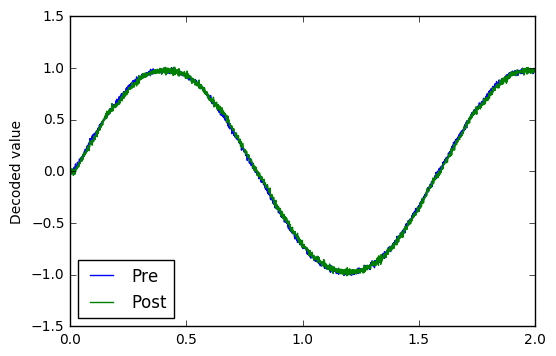

In [6]:
# Verify that it does a communication channel
with nengo.Simulator(model) as sim:
    sim.run(2.0)

plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.legend(loc="best");

## What does BCM do?

In [7]:
conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)
with model:
    weights_p = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

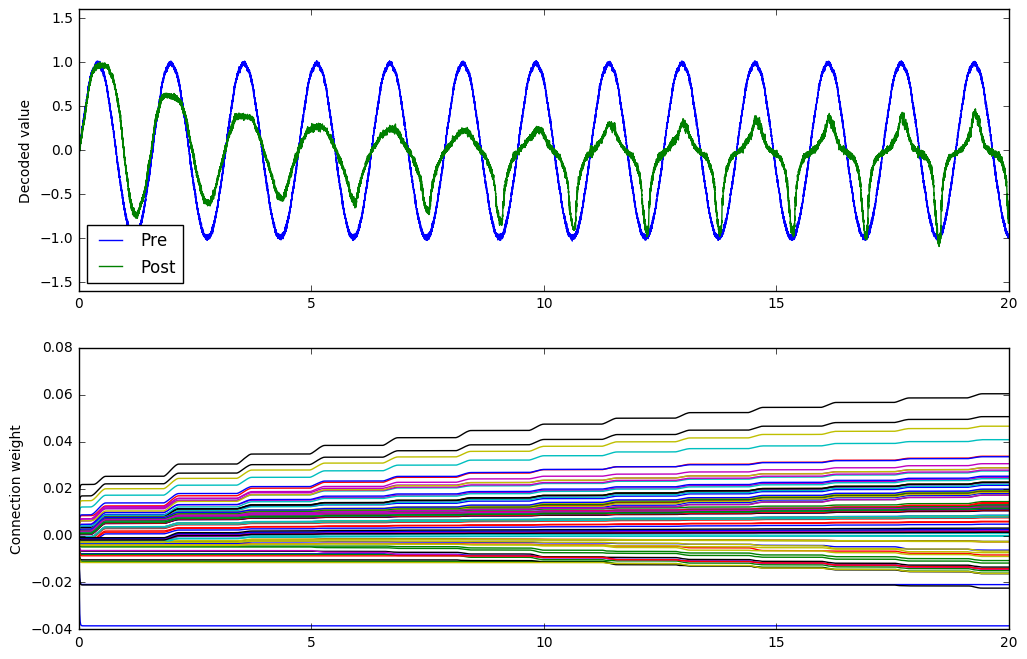

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[weights_p], axis=0), axis=1))
plt.plot(sim.trange(dt=0.01), sim.data[weights_p][..., neuron])
plt.ylabel("Connection weight");

The BCM rule appears to cause the ensemble
to either be on or off.
This seems consistent with the idea that it potentiates
active synapses, and depresses non-active synapses.

As well, we can show that BCM sparsifies the weights.
The sparsity measure below uses the Gini measure of sparsity,
for reasons explained [in this paper](http://arxiv.org/pdf/0811.4706.pdf).

In [11]:
def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

print("Starting sparsity: {0}".format(sparsity_measure(sim.data[weights_p][0])))
print("Ending sparsity: {0}".format(sparsity_measure(sim.data[weights_p][-1])))

Starting sparsity: 0.212144213395
Ending sparsity: 0.45812506075
